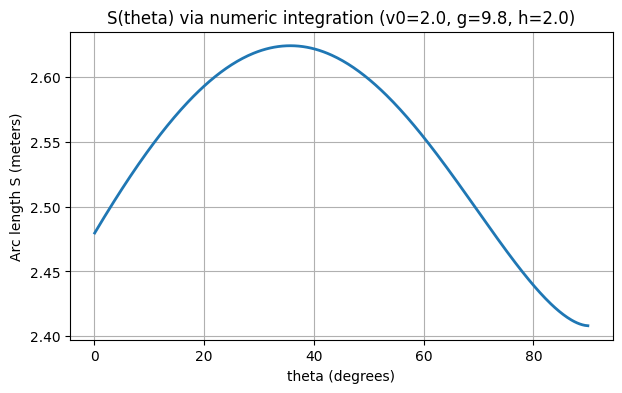

Maximizing theta (numeric): 35.770556 degrees
Maximum arc length S*: 2.624027 m
[CSV saved] /mnt/data/arc_length_scan.csv


In [3]:
# Numerical arc-length scan over launch angles for a projectile launched from height h.
# We integrate speed over time for each theta in [0, 90°] (radians inside the code).
# You can edit v0, g, h, and the angle grid.

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- Parameters (edit these) ---
v0 = 2.0     # m/s
g  = 9.8     # m/s^2
h  = 2.0     # m
n_angles = 361     # number of theta samples from 0.1° to 89.9°
n_time   = 2000    # time steps per integral (increase for more accuracy)
# --------------------------------

# Speed function pieces
def speed(t, theta, v0, g):
    return np.sqrt( (v0*np.cos(theta))**2 + (v0*np.sin(theta) - g*t)**2 )

def time_of_flight(theta, v0, g, h):
    # positive root of y(t)=0
    return (v0*np.sin(theta) + np.sqrt((v0*np.sin(theta))**2 + 2*g*h)) / g

# Closed-form S for cross-check
def S_closed(theta, v0, g, h):
    A = (v0*np.cos(theta))**2
    B = v0*np.sin(theta)
    term1 = A * (np.arcsinh(B/np.sqrt(A)) + np.arcsinh(np.sqrt(B**2 + 2*g*h)/np.sqrt(A)))
    term2 = B * np.sqrt(A + B**2)
    term3 = np.sqrt(B**2 + 2*g*h) * np.sqrt(A + B**2 + 2*g*h)
    return (term1 + term2 + term3) / (2*g)

# Angle grid (avoid exact 0 and 90 to keep everything finite/nice)
theta_deg = np.linspace(0.1, 89.9, n_angles)
theta = np.deg2rad(theta_deg)

S_num = np.empty_like(theta)
S_cl  = np.empty_like(theta)

# Numerical integration (trapezoid) for each theta
for i, th in enumerate(theta):
    tf = time_of_flight(th, v0, g, h)
    t  = np.linspace(0.0, tf, n_time)
    v  = speed(t, th, v0, g)
    # Trapezoidal rule
    S_num[i] = np.trapz(v, t)
    # Closed-form
    S_cl[i]  = S_closed(th, v0, g, h)

# Find maximizing theta from numeric integration
imax = int(np.nanargmax(S_num))
theta_star_deg = theta_deg[imax]
S_star = S_num[imax]

# Simple plot
plt.figure(figsize=(7,4))
plt.plot(theta_deg, S_num, linewidth=2)
plt.xlabel("theta (degrees)")
plt.ylabel("Arc length S (meters)")
plt.title(f"S(theta) via numeric integration (v0={v0}, g={g}, h={h})")
plt.grid(True)
plt.show()

# Prepare a table with a few representative rows and the max
df = pd.DataFrame({
    "theta_deg": theta_deg,
    "S_numeric_m": S_num,
    "S_closed_m": S_cl,
    "abs_error_m": np.abs(S_num - S_cl)
})

print(f"Maximizing theta (numeric): {theta_star_deg:.6f} degrees")
print(f"Maximum arc length S*: {S_star:.6f} m")
print(f"[CSV saved] {csv_path}")


In [4]:
import numpy as np
from scipy.integrate import quad
from scipy.optimize import minimize_scalar

# --- 1. Define constants and physical parameters ---
g = 9.81  # Acceleration due to gravity (m/s^2)
v0 = 2.0  # Initial speed (m/s)
y0 = 2.0  # Initial height (m)

# --- 2. Define a function for the time of flight T(theta) ---
def time_of_flight(theta):
    """
    Calculates the time of flight for a given launch angle theta.
    theta is in radians.
    """
    sin_theta = np.sin(theta)
    # Using the quadratic formula for T from y(T) = 0
    term_under_sqrt = (v0 * sin_theta)**2 + 2 * g * y0
    numerator = v0 * sin_theta + np.sqrt(term_under_sqrt)
    return numerator / g

# --- 3. Define the function for the arc length S(theta) ---
def arc_length(theta):
    """
    Calculates the total arc length of the trajectory for a given
    launch angle theta. theta is in radians.
    """
    # Define the integrand for the arc length integral
    # Integrand = sqrt(vx(t)^2 + vy(t)^2)
    # which simplifies to sqrt(v0^2 - 2*v0*g*sin(theta)*t + g^2*t^2)
    integrand = lambda t: np.sqrt(v0**2 - 2 * v0 * g * np.sin(theta) * t + (g * t)**2)
    
    # Calculate the upper limit of integration, T
    T = time_of_flight(theta)
    
    # Perform numerical integration from t=0 to t=T
    # quad returns a tuple (result, estimated_error)
    S, _ = quad(integrand, 0, T)
    
    return S

# --- 4. Find the angle theta that maximizes the arc length ---
# We want to maximize arc_length(theta), which is equivalent to
# minimizing -arc_length(theta).
objective_function = lambda theta: -arc_length(theta)

# The angle theta must be in the interval (0, pi/2).
# We use a small epsilon to avoid potential issues at the boundaries.
bounds = (1e-9, np.pi/2 - 1e-9)

# Use scipy's minimize_scalar to find the minimum of the negative function
result = minimize_scalar(objective_function, bounds=bounds, method='bounded')

# The optimal angle is the 'x' value of the result object
optimal_theta_rad = result.x
max_S = -result.fun  # The maximum arc length
optimal_theta_deg = np.degrees(optimal_theta_rad)

# --- 5. Print the results ---
print(f"Numerical Optimization Results:")
print(f"Optimal launch angle (radians): {optimal_theta_rad:.4f}")
print(f"Optimal launch angle (degrees): {optimal_theta_deg:.4f}")
print(f"Maximum arc length (meters): {max_S:.4f}")


# Final Answer Formatting
final_answer = f"{optimal_theta_deg:.1f} degrees"
print(f"\nFinal Answer: {final_answer}")



Numerical Optimization Results:
Optimal launch angle (radians): 0.6235
Optimal launch angle (degrees): 35.7248
Maximum arc length (meters): 2.6235

Final Answer: 35.7 degrees


Optimal angle: 35.7 degrees
Maximum arc length: 2.6240 m
Landing time: 0.7691 s


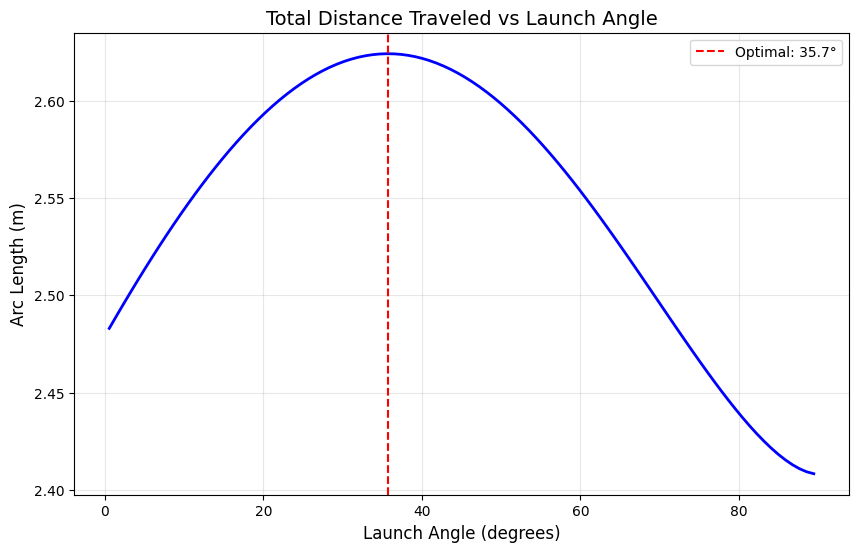

In [5]:
import numpy as np
from scipy.integrate import quad
from scipy.optimize import minimize_scalar

# Constants
y0 = 2.0  # initial height (m)
v0 = 2.0  # initial speed (m/s)
g = 9.8   # gravity (m/s^2)

def landing_time(theta):
    """Calculate when the ball lands (y=0)"""
    # From y = y0 + v0*sin(theta)*t - 0.5*g*t^2 = 0
    # Using quadratic formula: t = (v0*sin(theta) + sqrt((v0*sin(theta))^2 + 2*g*y0)) / g
    sin_theta = np.sin(theta)
    discriminant = (v0 * sin_theta)**2 + 2 * g * y0
    T = (v0 * sin_theta + np.sqrt(discriminant)) / g
    return T

def arc_length(theta):
    """Calculate the total distance traveled along the trajectory"""
    T = landing_time(theta)
    
    # Integrand: sqrt(vx^2 + vy^2)
    def speed(t):
        vx = v0 * np.cos(theta)
        vy = v0 * np.sin(theta) - g * t
        return np.sqrt(vx**2 + vy**2)
    
    length, _ = quad(speed, 0, T)
    return length

# Find the angle that maximizes arc length
# Note: minimize_scalar minimizes, so we negate the arc length
result = minimize_scalar(lambda theta: -arc_length(theta), 
                         bounds=(0.01, np.pi/2 - 0.01), 
                         method='bounded')

optimal_theta_rad = result.x
optimal_theta_deg = np.degrees(optimal_theta_rad)
max_arc_length = -result.fun

print(f"Optimal angle: {optimal_theta_deg:.1f} degrees")
print(f"Maximum arc length: {max_arc_length:.4f} m")
print(f"Landing time: {landing_time(optimal_theta_rad):.4f} s")

# Verify by plotting
import matplotlib.pyplot as plt

theta_range = np.linspace(0.01, np.pi/2 - 0.01, 100)
arc_lengths = [arc_length(theta) for theta in theta_range]

plt.figure(figsize=(10, 6))
plt.plot(np.degrees(theta_range), arc_lengths, 'b-', linewidth=2)
plt.axvline(optimal_theta_deg, color='r', linestyle='--', label=f'Optimal: {optimal_theta_deg:.1f}°')
plt.xlabel('Launch Angle (degrees)', fontsize=12)
plt.ylabel('Arc Length (m)', fontsize=12)
plt.title('Total Distance Traveled vs Launch Angle', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


In [7]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import minimize_scalar

# --- 1. Define Constants and Parameters ---

# Physical constants
g = 9.81  # Acceleration due to gravity (m/s^2)
rho = 1.225  # Air density (kg/m^3)
Cd = 0.35  # Drag coefficient
r = 0.0366  # Radius of the baseball (m)
m = 0.145  # Mass of the baseball (kg)

# Derived drag parameters
A = np.pi * r**2  # Cross-sectional area (m^2)
b = 0.5 * rho * Cd * A  # Drag constant
k = b / m  # Drag constant divided by mass

# Initial conditions
y0 = 2.0  # Initial height (m)
v0 = 2.0  # Initial speed (m/s)

# --- 2. Define the System of ODEs ---

# State vector: [x, y, vx, vy, S]
# S is the arc length
def derivatives(t, state):
    x, y, vx, vy, S = state
    
    speed = np.sqrt(vx**2 + vy**2)
    
    # Avoid division by zero if speed is 0, though unlikely here
    if speed == 0:
        return [0, 0, 0, -g, 0]
        
    dxdt = vx
    dydt = vy
    dvxdt = -k * speed * vx
    dvydt = -g - k * speed * vy
    dSdt = speed  # The rate of change of arc length is the speed
    
    return [dxdt, dydt, dvxdt, dvydt, dSdt]

# --- 3. Define the Event for Hitting the Ground ---

def hit_ground(t, state):
    # Event function: returns y-coordinate. Solver finds where this is zero.
    return state[1]

hit_ground.terminal = True  # Stop the integration when the event occurs
hit_ground.direction = -1   # Event triggers only when y is decreasing

# --- 4. Function to Calculate Arc Length for a Given Angle ---

def calculate_arc_length(theta_deg):
    """
    Calculates the total arc length for a projectile launched at theta_deg.
    """
    theta_rad = np.radians(theta_deg)
    
    # Initial conditions based on the launch angle
    vx0 = v0 * np.cos(theta_rad)
    vy0 = v0 * np.sin(theta_rad)
    initial_state = [0, y0, vx0, vy0, 0] # x, y, vx, vy, S
    
    # Time span for integration (a safe upper bound)
    t_span = [0, 5]
    
    # Solve the ODE system
    sol = solve_ivp(
        fun=derivatives,
        t_span=t_span,
        y0=initial_state,
        events=hit_ground,
        dense_output=True # Needed to accurately find event time
    )
    
    # Check if the event (hitting the ground) was triggered
    if sol.status == 1 and len(sol.y_events[0]) > 0:
        # The final state at the time of the event
        final_state_at_event = sol.y_events[0][0]
        # The arc length is the 5th element (index 4) of the state vector
        arc_length = final_state_at_event[4]
        return arc_length
    else:
        # Return 0 or NaN if the simulation fails (e.g., doesn't hit the ground)
        return 0

# --- 5. Optimization to Find the Maximum Arc Length ---

# We want to maximize the arc length, which is equivalent to
# minimizing its negative.
def objective_function(theta_deg):
    return -calculate_arc_length(theta_deg)

# Perform the optimization over the interval (0, 90) degrees
# We use a bounded method to stay within the physical range.
result = minimize_scalar(
    fun=objective_function,
    bounds=(0.1, 89.9), # Search within (0, 90) degrees
    method='bounded'
)

# --- 6. Display the Results ---

optimal_theta = result.x
max_arc_length = -result.fun

# For context, let's also calculate the horizontal range at this angle
theta_rad_opt = np.radians(optimal_theta)
vx0_opt = v0 * np.cos(theta_rad_opt)
vy0_opt = v0 * np.sin(theta_rad_opt)
initial_state_opt = [0, y0, vx0_opt, vy0_opt, 0]
sol_opt = solve_ivp(derivatives, [0, 5], initial_state_opt, events=hit_ground, dense_output=True)
final_x_pos = sol_opt.y_events[0][0][0]

print(f"Optimization complete.")
print(f"Optimal launch angle: {optimal_theta:.4f} degrees")
print(f"Maximum arc length: {max_arc_length:.4f} meters")
print(f"Horizontal range at this angle: {final_x_pos:.4f} meters")



Optimization complete.
Optimal launch angle: 35.2231 degrees
Maximum arc length: 2.6205 meters
Horizontal range at this angle: 1.2478 meters


In [8]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import minimize_scalar

# Constants
rho = 1.225  # kg/m^3
C_d = 0.35
r = 0.0366  # m
A = np.pi * r**2
m = 0.145  # kg
g = 9.81  # m/s^2
y0 = 2.0  # m
v0 = 2.0  # m/s

# Drag coefficient
k = 0.5 * rho * C_d * A / m

print(f"Drag coefficient k: {k:.6f}")
print(f"Cross-sectional area A: {A:.6f} m^2")

def equations(t, state):
    """
    state = [x, y, vx, vy]
    Returns derivatives [dx/dt, dy/dt, dvx/dt, dvy/dt]
    """
    x, y, vx, vy = state
    
    v_mag = np.sqrt(vx**2 + vy**2)
    
    # Accelerations from drag and gravity
    ax = -k * v_mag * vx
    ay = -g - k * v_mag * vy
    
    return [vx, vy, ax, ay]

def hit_ground(t, state):
    """Event function to detect when ball hits ground (y=0)"""
    return state[1]

hit_ground.terminal = True
hit_ground.direction = -1

def calculate_arc_length(theta):
    """Calculate total arc length traveled for a given launch angle"""
    # Initial conditions
    vx0 = v0 * np.cos(theta)
    vy0 = v0 * np.sin(theta)
    state0 = [0, y0, vx0, vy0]
    
    # Solve ODEs until ball hits ground
    sol = solve_ivp(equations, [0, 10], state0, 
                    events=hit_ground, dense_output=True, 
                    max_step=0.001, rtol=1e-9, atol=1e-12)
    
    # Calculate arc length: integrate |v| dt
    # Arc length = ∫ sqrt(vx^2 + vy^2) dt
    t_vals = sol.t
    vx_vals = sol.y[2]
    vy_vals = sol.y[3]
    
    arc_length = 0
    for i in range(1, len(t_vals)):
        # Use trapezoidal rule for integration
        v_mag_i = np.sqrt(vx_vals[i]**2 + vy_vals[i]**2)
        v_mag_im1 = np.sqrt(vx_vals[i-1]**2 + vy_vals[i-1]**2)
        dt = t_vals[i] - t_vals[i-1]
        arc_length += 0.5 * (v_mag_i + v_mag_im1) * dt
    
    return arc_length

# Find optimal angle by minimizing negative arc length
def negative_arc_length(theta):
    return -calculate_arc_length(theta)

# Search for optimal angle
result = minimize_scalar(negative_arc_length, bounds=(0.01, np.pi/2 - 0.01), 
                        method='bounded', options={'xatol': 1e-6})

optimal_theta = result.x
optimal_theta_deg = np.degrees(optimal_theta)
max_arc_length = -result.fun

print(f"\nOptimal launch angle: {optimal_theta_deg:.1f} degrees")
print(f"Maximum arc length: {max_arc_length:.4f} m")

# Verify by testing nearby angles
print("\nVerification (arc length vs angle):")
test_angles = np.linspace(optimal_theta_deg - 5, optimal_theta_deg + 5, 11)
for angle_deg in test_angles:
    angle_rad = np.radians(angle_deg)
    arc = calculate_arc_length(angle_rad)
    print(f"  {angle_deg:.1f}°: {arc:.4f} m")


Drag coefficient k: 0.006222
Cross-sectional area A: 0.004208 m^2

Optimal launch angle: 35.8 degrees
Maximum arc length: 2.6211 m

Verification (arc length vs angle):
  30.8°: 2.6179 m
  31.8°: 2.6191 m
  32.8°: 2.6200 m
  33.8°: 2.6206 m
  34.8°: 2.6210 m
  35.8°: 2.6211 m
  36.8°: 2.6210 m
  37.8°: 2.6206 m
  38.8°: 2.6200 m
  39.8°: 2.6191 m
  40.8°: 2.6179 m


In [9]:
rho = 1.225  # kg/m^3
C_d = 0.35
r = 0.0366  # m
A = np.pi * r**2
m = 0.145  # kg
g = 9.81  # m/s^2
y0 = 2.0  # m
v0 = 2.0  # m/s

# Drag coefficient
k = 0.5 * rho * C_d * A / m

k

0.006221830544308884

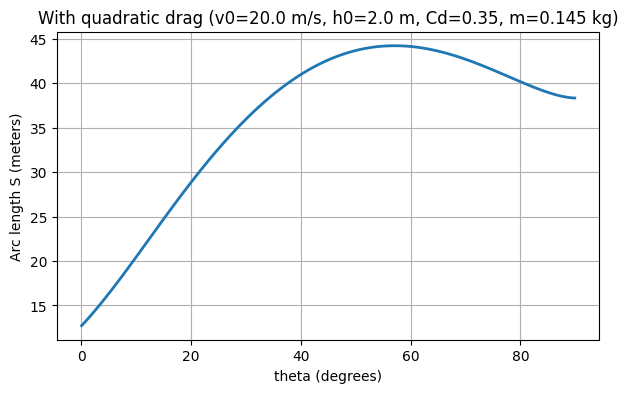

Optimal theta ≈ 56.9733 degrees
Max arc length S* ≈ 44.221796 m


In [11]:
# Projectile with quadratic air drag: optimize launch angle for maximum arc length.
# We'll integrate the equations of motion with drag and accumulate arc length,
# then sweep angles to find the maximizer.
#
# You can edit the physical parameters below.
import numpy as np
import matplotlib.pyplot as plt
from math import pi
from scipy.integrate import solve_ivp
import pandas as pd

# ------------------ Parameters (edit these) ------------------
g   = 9.81          # m/s^2
v0  = 20.0          # m/s (set to 2.0 to match earlier tiny-speed example)
h0  = 2.0           # m, launch height
rho = 1.225         # kg/m^3, air density at sea level
Cd  = 0.35          # drag coefficient (baseball in flight ~0.3-0.5)
r   = 0.0366        # m, baseball radius
A   = np.pi*r**2    # frontal area
m   = 0.145         # kg, baseball mass
# Integration controls
tmax = 30.0         # s, safety cap
atol = 1e-9
rtol = 1e-9
# Angle sweep
theta_min_deg = 0.1
theta_max_deg = 89.9
n_angles = 121    # number of angle samples in sweep
# -------------------------------------------------------------

k = 0.5*rho*Cd*A   # drag constant so that Fd = k * v * v_vec

def rhs(t, Y):
    # State Y = [x, y, vx, vy, S] where S is arc length so far
    x, y, vx, vy, S = Y
    v = np.hypot(vx, vy) + 1e-15  # avoid division by zero
    ax = -(k/m) * v * vx
    ay = -g - (k/m) * v * vy
    dS = v
    return [vx, vy, ax, ay, dS]

def hit_ground(t, Y):
    # Event when y crosses zero from above
    return Y[1]
hit_ground.terminal = True
hit_ground.direction = -1

def flight_arc_length(theta, v0=v0):
    vx0 = v0*np.cos(theta)
    vy0 = v0*np.sin(theta)
    Y0 = [0.0, h0, vx0, vy0, 0.0]
    sol = solve_ivp(rhs, [0, tmax], Y0, atol=atol, rtol=rtol, events=hit_ground, max_step=0.02)
    if sol.status == 1 and len(sol.t_events[0]) > 0:
        S_final = sol.y[4, -1]  # accumulated arc length at impact
        return S_final, sol
    else:
        # If it didn't hit ground within tmax, return NaN
        return np.nan, sol

# Sweep angles
theta_deg = np.linspace(theta_min_deg, theta_max_deg, n_angles)
theta_rad = np.deg2rad(theta_deg)
S_vals = np.empty_like(theta_rad)
for i, th in enumerate(theta_rad):
    S, _ = flight_arc_length(th, v0=v0)
    S_vals[i] = S

imax = int(np.nanargmax(S_vals))
theta_star_deg = theta_deg[imax]
S_star = S_vals[imax]

# Plot S(theta)
plt.figure(figsize=(7,4))
plt.plot(theta_deg, S_vals, linewidth=2)
plt.xlabel("theta (degrees)")
plt.ylabel("Arc length S (meters)")
plt.title(f"With quadratic drag (v0={v0} m/s, h0={h0} m, Cd={Cd}, m={m} kg)")
plt.grid(True)
plt.show()

print(f"Optimal theta ≈ {theta_star_deg:.4f} degrees")
print(f"Max arc length S* ≈ {S_star:.6f} m")

# Provide table to user
df = pd.DataFrame({"theta_deg": theta_deg, "S_m": S_vals})



Gravitational parameter μ = 398602.54 km³/s²

Sample calculations:
e = 0.0: distance = 7576.20 km, period = 9951.99 s
e = 0.3: distance = 7414.34 km, period = 9951.99 s
e = 0.6: distance = 8475.43 km, period = 9951.99 s
e = 0.9: distance = 10872.18 km, period = 9951.99 s

Optimal eccentricity: e = 0.187
Minimum distance traveled: 7328.32 km

Plot saved as 'orbit_distance.png'


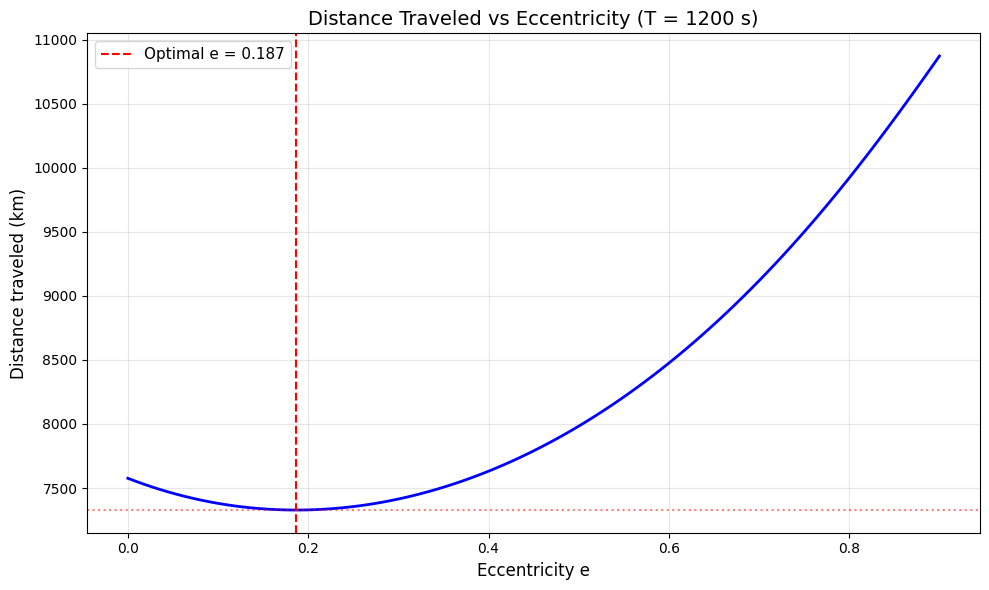

In [12]:
import numpy as np
from scipy.optimize import fsolve, minimize_scalar
from scipy.integrate import quad
import matplotlib.pyplot as plt

# Constants
G = 6.67430e-20  # km^3 kg^-1 s^-2
M_earth = 5.9722e24  # kg
mu = G * M_earth  # km^3/s^2
a = 10000  # km
T = 1200  # s
nu0 = np.pi / 2  # 90 degrees

print(f"Gravitational parameter μ = {mu:.2f} km³/s²")

def true_to_eccentric(nu, e):
    """Convert true anomaly to eccentric anomaly"""
    # Using tan(nu/2) = sqrt((1+e)/(1-e)) * tan(E/2)
    E = 2 * np.arctan2(np.sqrt(1-e) * np.sin(nu/2), 
                       np.sqrt(1+e) * np.cos(nu/2))
    return E

def eccentric_to_mean(E, e):
    """Calculate mean anomaly from eccentric anomaly"""
    return E - e * np.sin(E)

def solve_kepler(M, e, E_guess=None):
    """Solve Kepler's equation M = E - e*sin(E) for E"""
    if E_guess is None:
        E_guess = M
    
    # Newton-Raphson iteration
    E = E_guess
    for _ in range(50):
        f = E - e * np.sin(E) - M
        fp = 1 - e * np.cos(E)
        E_new = E - f / fp
        if abs(E_new - E) < 1e-12:
            break
        E = E_new
    return E

def arc_length_integrand(E, e):
    """Integrand for arc length: sqrt(1 - e²cos²(E))"""
    return np.sqrt(1 - e**2 * np.cos(E)**2)

def distance_traveled(e):
    """Calculate distance traveled along orbit for given eccentricity"""
    # Mean motion
    n = np.sqrt(mu / a**3)
    
    # Initial eccentric anomaly at nu = 90°
    E0 = true_to_eccentric(nu0, e)
    
    # Initial mean anomaly
    M0 = eccentric_to_mean(E0, e)
    
    # Mean anomaly at time T
    MT = M0 + n * T
    
    # Handle wrapping: normalize to [0, 2π)
    # Count complete orbits
    period = 2 * np.pi / n
    n_orbits = int(MT / (2 * np.pi))
    MT_normalized = MT % (2 * np.pi)
    
    # Eccentric anomaly at time T
    ET = solve_kepler(MT_normalized, e, E_guess=MT_normalized)
    
    # Calculate arc length from E0 to ET
    if n_orbits == 0:
        # No complete orbits
        if ET >= E0:
            arc, _ = quad(arc_length_integrand, E0, ET, args=(e,), 
                         limit=100, epsabs=1e-10)
        else:
            # Wrapped around once
            arc1, _ = quad(arc_length_integrand, E0, 2*np.pi, args=(e,), 
                          limit=100, epsabs=1e-10)
            arc2, _ = quad(arc_length_integrand, 0, ET, args=(e,), 
                          limit=100, epsabs=1e-10)
            arc = arc1 + arc2
    else:
        # Add complete orbits
        full_orbit, _ = quad(arc_length_integrand, 0, 2*np.pi, args=(e,), 
                            limit=100, epsabs=1e-10)
        
        if ET >= E0:
            partial, _ = quad(arc_length_integrand, E0, ET, args=(e,), 
                            limit=100, epsabs=1e-10)
            arc = n_orbits * full_orbit + partial
        else:
            arc1, _ = quad(arc_length_integrand, E0, 2*np.pi, args=(e,), 
                          limit=100, epsabs=1e-10)
            arc2, _ = quad(arc_length_integrand, 0, ET, args=(e,), 
                          limit=100, epsabs=1e-10)
            arc = n_orbits * full_orbit + arc1 + arc2
    
    # Multiply by scale factor 'a'
    return a * arc

# Test a few values
print("\nSample calculations:")
for e_test in [0.0, 0.3, 0.6, 0.9]:
    if e_test <= 0.90:
        dist = distance_traveled(e_test)
        period = 2 * np.pi * np.sqrt(a**3 / mu)
        print(f"e = {e_test:.1f}: distance = {dist:.2f} km, period = {period:.2f} s")

# Find optimal eccentricity
result = minimize_scalar(distance_traveled, bounds=(0, 0.90), 
                        method='bounded', options={'xatol': 1e-6})

optimal_e = result.x
min_distance = result.fun

print(f"\n{'='*50}")
print(f"Optimal eccentricity: e = {optimal_e:.3f}")
print(f"Minimum distance traveled: {min_distance:.2f} km")
print(f"{'='*50}")

# Create a plot
e_values = np.linspace(0, 0.90, 100)
distances = [distance_traveled(e) for e in e_values]

plt.figure(figsize=(10, 6))
plt.plot(e_values, distances, 'b-', linewidth=2)
plt.axvline(optimal_e, color='r', linestyle='--', 
            label=f'Optimal e = {optimal_e:.3f}')
plt.axhline(min_distance, color='r', linestyle=':', alpha=0.5)
plt.xlabel('Eccentricity e', fontsize=12)
plt.ylabel('Distance traveled (km)', fontsize=12)
plt.title('Distance Traveled vs Eccentricity (T = 1200 s)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.savefig('orbit_distance.png', dpi=150)
print("\nPlot saved as 'orbit_distance.png'")
